In [10]:
#source https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [11]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time
import json

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [12]:
def smape(predictions, actual):
    difference = np.absolute(actual-predictions)
    summation = actual+predictions
    error = 100/len(predictions)*np.sum(2*difference/summation)
    return error

Because we are in forecasting mode, we cannot shuffle the data for evaluation. Instead we are going to use *walk-forward validation*.<br><br>
In walk-forward validation, the dataset is first split into train and test sets using a cut-point. If we are interested in one time-step forecast, then we can evaluate the model by training on the training sset and predicting first step in the test dataset. Then add the real observation from test set to the training, refit the model, predict the second step and so on...

In [13]:
# walk-forward validation for univariate data
def walk_forward_validation(train, test):
    predictions = []
    history = train.copy()
    
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        #target y is the first column in the dataset
        test_X, test_y = test.iloc[i, 1:], test.iloc[i, 0]
        
        #test_X is a series, but our model was trained on dataframe
        test_X = test_X.to_frame().T.reset_index(drop = True)
        
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, test_X)
        predictions.append(yhat)
        
        #appending test observation to training requires transforming it to dataframe
        new_data = test.iloc[i].to_frame().T.reset_index(drop = True)
        # add actual observation to training data for the next loop
        history = history.append(new_data, ignore_index = True)
        
    # estimate prediction error
    error = smape(predictions, test.iloc[:, 0], )
    
    return error, test.iloc[:, 0].reset_index(drop = True), predictions

The *xgboost_forecast()* function takes training dataset and test input row as input, fitting the model and making one-step prediction.

In [14]:
def xgboost_forecast(train, test_X):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 100, random_state = 40)
    model.fit(train_X, train_y)
    yhat = model.predict(test_X)
    
    return yhat[0]

In [15]:
def preprocessing(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #train/test split
    train, test = data[:int(0.7*n)], data[int(0.7*n):]    
    
    return train, test

In [16]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
                "linear1_inc", "linear2_inc", "linear3_inc",
                "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]

Time wasted: 15.31s


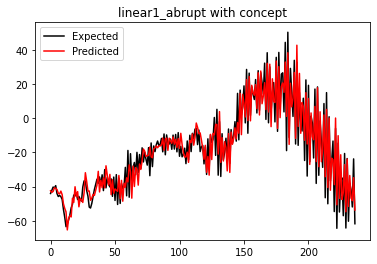

Time wasted: 14.46s


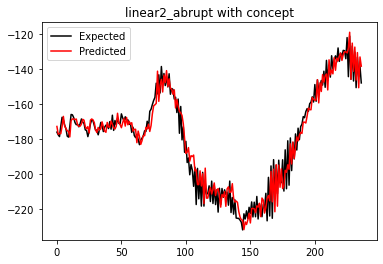

Time wasted: 13.98s


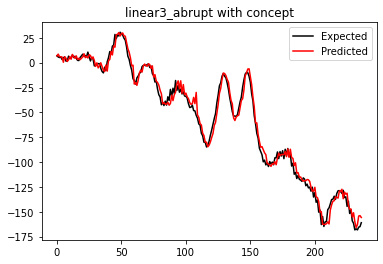

Time wasted: 14.06s


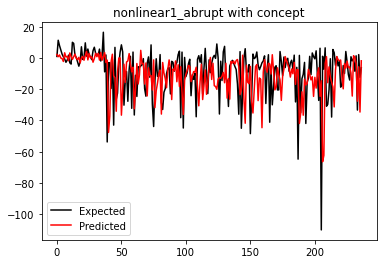

Time wasted: 13.92s


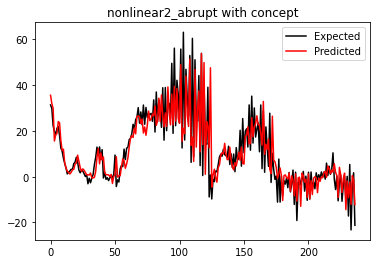

Time wasted: 15.85s


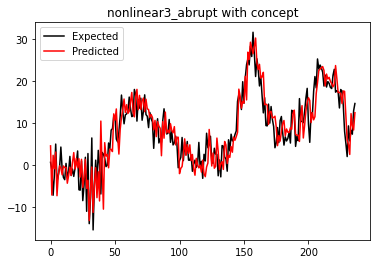

Time wasted: 15.43s


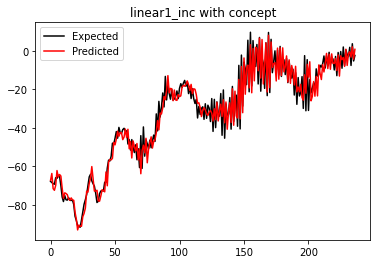

Time wasted: 16.93s


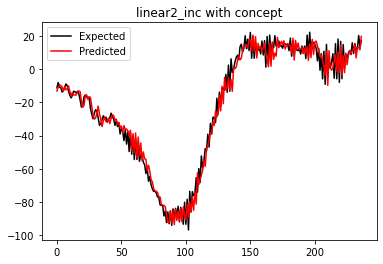

Time wasted: 15.66s


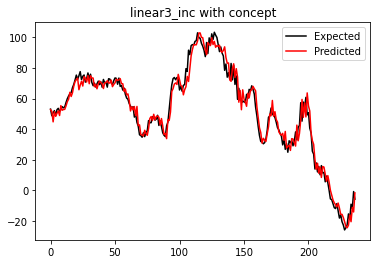

Time wasted: 15.95s


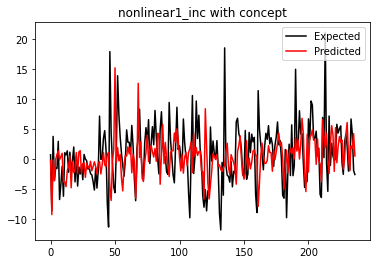

Time wasted: 18.52s


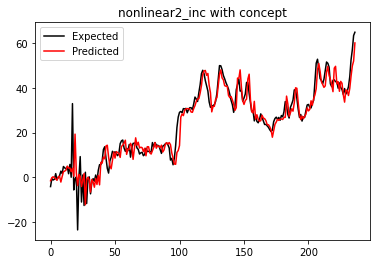

Time wasted: 17.37s


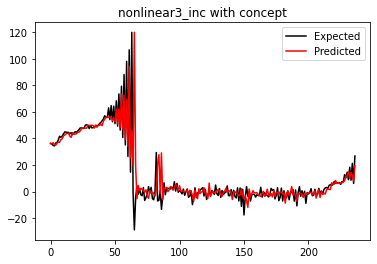

In [19]:
smape_dict_with = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #simple preprocessing
    train, test = preprocessing(data)
    
    #fitting and plotting with concept
    start = time.perf_counter()
    error, y, yhat = walk_forward_validation(train, test)
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    smape_dict_with[name] = error
    plt.plot(y, label = "Expected", color = "black")
    plt.plot(yhat, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} with concept".format(name))
    
    #saving the plots
    image_path = "forecasting_results/xgboost/with/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()

#saving the dictionary containing errors
dict_path = "forecasting_results/xgboost/with/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_with))

Time wasted: 13.28s


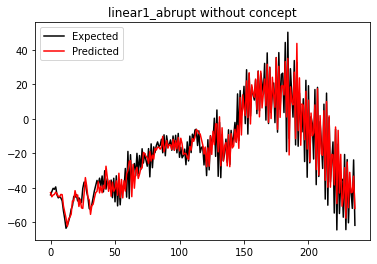

Time wasted: 14.78s


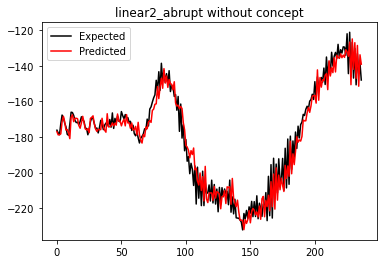

Time wasted: 16.54s


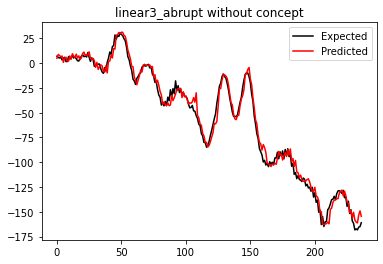

Time wasted: 22.20s


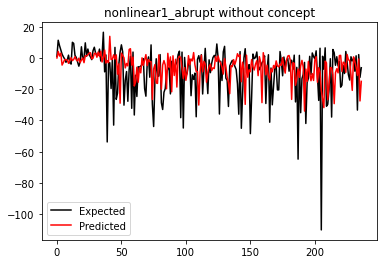

Time wasted: 14.21s


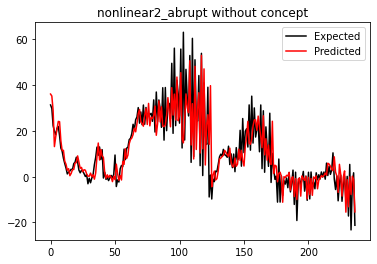

Time wasted: 18.44s


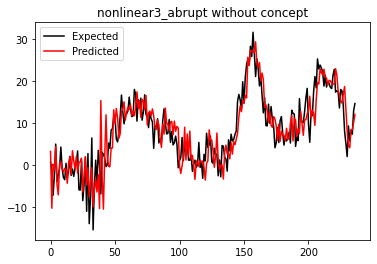

Time wasted: 16.25s


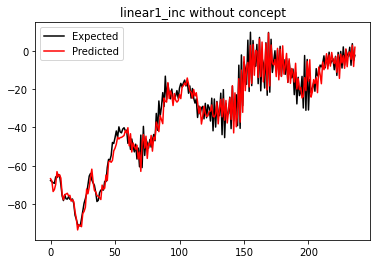

Time wasted: 16.99s


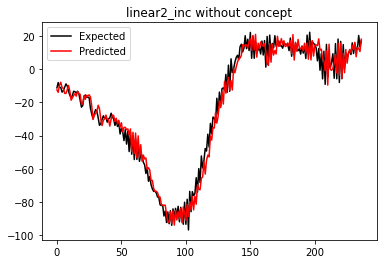

Time wasted: 22.13s


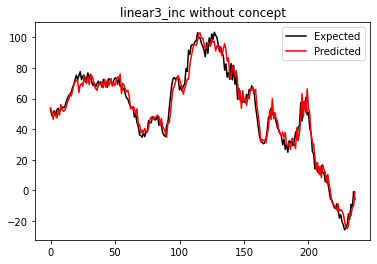

Time wasted: 17.00s


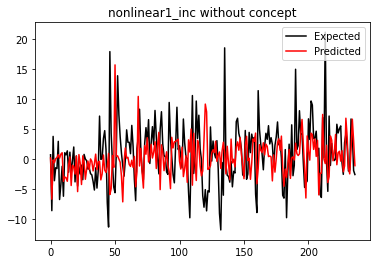

Time wasted: 18.57s


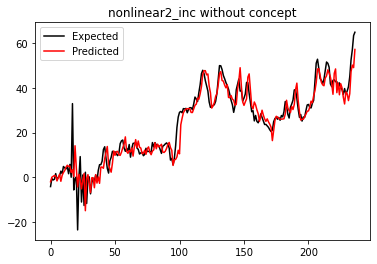

Time wasted: 20.13s


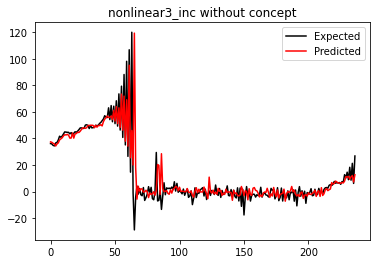

In [20]:
smape_dict_without = {}

for name in list_of_names:
    #loading the data
    file_path = "data/"+name
    data = pd.read_csv(file_path)
    
    #simple preprocessing
    train, test = preprocessing(data)
    
    #fitting and plotting with concept
    start = time.perf_counter()
    error, y, yhat = walk_forward_validation(train.loc[:,"t":"t-5"], test.loc[:,"t":"t-5"])
    end = time.perf_counter()
    print("Time wasted: {:.2f}s".format((end-start)))
    
    smape_dict_without[name] = error
    plt.plot(y, label = "Expected", color = "black")
    plt.plot(yhat, label = "Predicted", color = "red")
    plt.legend()
    plt.title("{} without concept".format(name))
    
    #saving the plots
    image_path = "forecasting_results/xgboost/without/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()
    
#saving the dictionary containing errors
dict_path = "forecasting_results/xgboost/without/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict_without))